# Forward resnet model for scattering prediction

## Import modules

In [1]:
import os
import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

import matplotlib.pyplot as plt
import numpy as np
import h5py

import helper  # some helper functions

# Dynamic GPU memory allocation: For local prototyping, don't block GPU
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

2023-07-03 14:30:20.770275: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-03 14:30:21.265393: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-07-03 14:30:22.190898: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-03 14:30:22.209147: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA n

## Data loading

Here we load the data saved in the data generation tutorial. As the thicknesses and materials have a large difference in values and different units, they are normalized with _MinMaxScaler_ scaler in [0,1] range. Otherwise the network training would be disrupted. Thickness and material data are concatenated in channel dimension and split into training and test sets.

*Note*: We demonstrate the data loading and normalization here explicitly. In the further notebooks it is done using functions from the provided *helper* module.

In [2]:
data_path = 'datasets/dataset3_nanoscat.h5'

with h5py.File(data_path, "r") as f:
    geo = np.array(f['geo2d'], dtype=np.float32)
    scatspec = np.array(f['scatspec'], dtype=np.float32)
wavelegnths = np.linspace(500, 1000, 50)

# lazy normalization
sc_norm = 3100000
scatspec /= sc_norm
geo = geo*2 - 1     # rescale from -1 to 1

sc_train, sc_val, geo_train, geo_val = train_test_split(
                scatspec, geo, test_size=0.1, shuffle=True, random_state=12345)

# define a ResNet

In [3]:
def resblock_2D_sequence_down(x_in, N_filter, N_blocks, with_BN):
    x = x_in
    for i in range(N_blocks):
        x = helper.residual_block(
            x, N_filter, conv_layer=keras.layers.Conv2D,
            kernel_size=3, strides=1, with_BN=with_BN)
    # down: use strides=2 for downsampling (more flexible, since trainable).
    x = helper.residual_block(
        x, N_filter, conv_layer=keras.layers.Conv2D,
        kernel_size=3, strides=2, with_BN=with_BN)
    return x


def resblock_1D_sequence_up(x_in, N_filter, N_blocks, with_BN):
    x = x_in
    for i in range(N_blocks):
        x = helper.residual_block(
            x, N_filter, conv_layer=keras.layers.Conv1DTranspose,
            kernel_size=3, strides=1, with_BN=with_BN)
    # up: use upsampling (more robust than transpose convolutions with stride 2)
    x = keras.layers.UpSampling1D()(x)
    return x


def resblock_1D_sequence_id(x_in, N_filter, N_blocks, with_BN):
    x = x_in
    for i in range(N_blocks):
        x = helper.residual_block(
            x, N_filter, conv_layer=keras.layers.Conv1DTranspose,
            kernel_size=3, strides=1, with_BN=with_BN)
    return x

In [4]:
keras.backend.clear_session()
BN = True
N_blocks = 4     # Nr of resblocks between upsamplings


# input
geo_in = keras.layers.Input(shape=geo_train.shape[1:])   # geometry
x = geo_in

x = resblock_2D_sequence_down(
    x, N_filter=64, N_blocks=N_blocks, with_BN=BN)   # 20 --> 10
x = resblock_2D_sequence_down(
    x, N_filter=128, N_blocks=N_blocks, with_BN=BN)  # 10 --> 5
x = resblock_2D_sequence_down(
    x, N_filter=256, N_blocks=N_blocks, with_BN=BN)  # 5 --> 3

# reshape 2D (3, 3, 256) --> 1D (3, 3*256)
x = keras.layers.Reshape((3, 3*256))(x)

x = resblock_1D_sequence_up(
    x, N_filter=256, N_blocks=N_blocks, with_BN=BN)   # 3 --> 6
x = resblock_1D_sequence_up(
    x, N_filter=128, N_blocks=N_blocks, with_BN=BN)   # 6 --> 12
x = resblock_1D_sequence_up(
    x, N_filter=64, N_blocks=N_blocks, with_BN=BN)   # 12 --> 24
x = keras.layers.ZeroPadding1D((0, 1))(x)      # 24 --> 25
x = resblock_1D_sequence_up(
    x, N_filter=64, N_blocks=N_blocks, with_BN=BN)   # 25 --> 50

x = resblock_1D_sequence_id(
    x, N_filter=64, N_blocks=N_blocks, with_BN=BN)   # 50 --> 50

# output
spectra_out = keras.layers.Conv1D(
    sc_train.shape[-1], kernel_size=1, padding='same')(x)  # linear activation

# full model
fwd_model = keras.Model(geo_in, spectra_out)
fwd_model.summary()


2023-07-03 14:30:22.835988: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-03 14:30:22.836188: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-03 14:30:22.836311: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 20, 20, 1)]  0           []                               
                                                                                                  
 conv2d_1 (Conv2D)              (None, 20, 20, 64)   128         ['input_1[0][0]']                
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 20, 20, 64)   0           ['conv2d_1[0][0]']               
                                                                                                  
 conv2d_2 (Conv2D)              (None, 20, 20, 64)   36928       ['leaky_re_lu[0][0]']            
                                                                                              

## ResNet model training

Epoch 1/20


2023-07-03 14:30:34.184236: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-07-03 14:30:36.735583: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f5cf2dae760 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-03 14:30:36.735602: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2023-07-03 14:30:36.738894: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-03 14:30:36.859742: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


900/900 [==============================] - 67s 43ms/step - loss: 0.2497 - val_loss: 6.9720e-04 - lr: 0.0010
Epoch 2/20
900/900 [==============================] - 38s 43ms/step - loss: 5.4761e-04 - val_loss: 3.9496e-04 - lr: 0.0010
Epoch 3/20
900/900 [==============================] - 40s 44ms/step - loss: 3.5513e-04 - val_loss: 3.5548e-04 - lr: 0.0010
Epoch 4/20
900/900 [==============================] - 40s 45ms/step - loss: 2.5562e-04 - val_loss: 2.5231e-04 - lr: 0.0010
Epoch 5/20
900/900 [==============================] - 39s 43ms/step - loss: 2.1200e-04 - val_loss: 1.7807e-04 - lr: 0.0010
Epoch 6/20
900/900 [==============================] - 40s 44ms/step - loss: 1.7740e-04 - val_loss: 1.7018e-04 - lr: 0.0010
Epoch 7/20
900/900 [==============================] - 40s 44ms/step - loss: 1.6518e-04 - val_loss: 1.5231e-04 - lr: 0.0010
Epoch 8/20
900/900 [==============================] - 39s 43ms/step - loss: 1.5390e-04 - val_loss: 1.4700e-04 - lr: 0.0010
Epoch 9/20
900/900 [===========

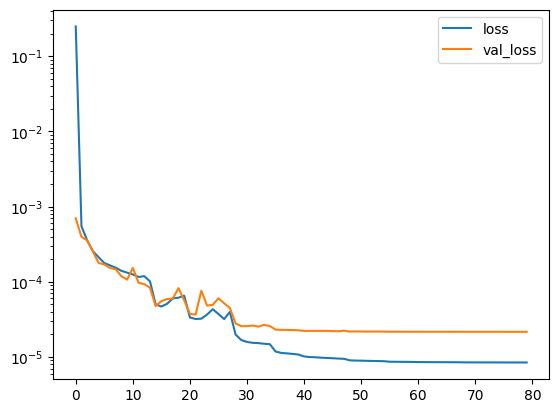

In [5]:
# compile with optimizer and cost function
fwd_model.compile(optimizer=keras.optimizers.AdamW(learning_rate=0.001),
                     loss='mse')

# atuomatic learning rate reduction
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=1/3, patience=7, verbose=1)

# fit config
train_kwargs = dict(x=geo_train, y=sc_train, validation_data=(geo_val, sc_val),
                    epochs=20, callbacks=[reduce_lr])

# fit the model with BN --> increasing batchsize schdedule
hist = None  # global history after BS incrase
for i in range(4):  # 4 x 20 epochs, increasing batchsize
    _h = fwd_model.fit(batch_size=(16 * 2**i), **train_kwargs)
    if hist is None:
        hist = _h
    else:
        for k in hist.history:
            hist.history[k] = np.concatenate([hist.history[k], _h.history[k]])

# plot loss
plt.figure()
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.yscale('log')
plt.legend()
plt.show()

# save
fwd_model.save('models/fwd_model_nanoscat.h5')

In [6]:
fwd_model_path = 'models/fwd_model_nanoscat.h5'

# load pretrained forward model
fwd_model = keras.models.load_model(fwd_model_path)

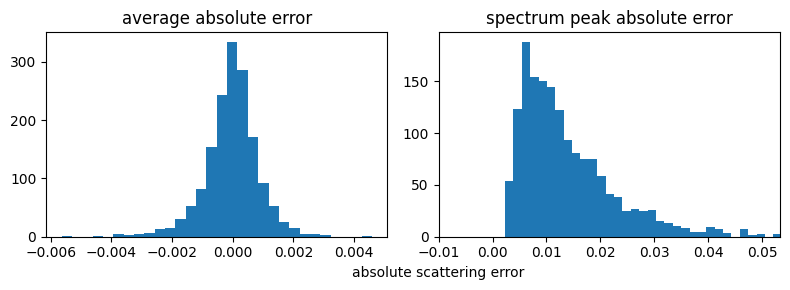

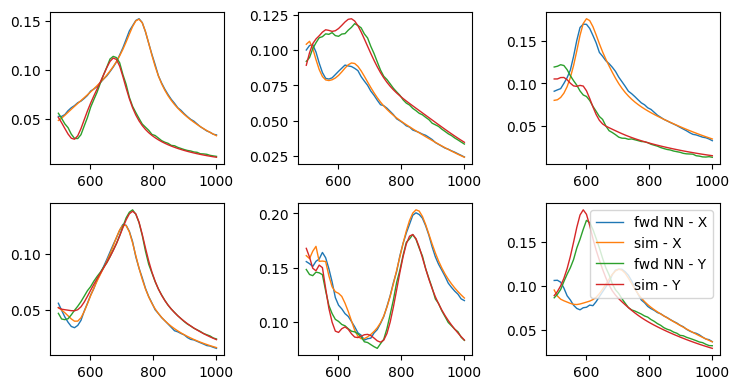

In [8]:
sc_predict = fwd_model.predict(geo_val, verbose=0)
N_plot = (2, 3)

# plot statistics
err = sc_predict - sc_val
err_mean = np.mean(err, axis=(1,2))
err_max = np.max(np.abs(err), axis=(1,2))
plt.figure(figsize=(8,3))
plt.subplot(121, title='average absolute error')
plt.hist(err_mean, bins=30)
plt.subplot(122, title='spectrum peak absolute error')
plt.hist(err_max, bins=50)
plt.xlabel('absolute scattering error', x=0)
plt.xlim(-0.01, np.quantile(err_max, 0.995)) # don't plot outliers
plt.tight_layout()
plt.show()

# plot samples
if N_plot is not None:
    plt.figure(figsize=(2.5*N_plot[1], 2*N_plot[0]))
    idx_rnd = np.random.randint(len(geo_val), size=np.prod(N_plot))
    for i, index in enumerate(idx_rnd):
        plt.subplot(N_plot[0], N_plot[1], i+1)
        plt.plot(wavelegnths, sc_predict[index][:,0], label='fwd NN - X', linewidth=1)
        plt.plot(wavelegnths, sc_val[index][:,0], label='sim - X', linewidth=1)
        plt.plot(wavelegnths, sc_predict[index][:,1], label='fwd NN - Y', linewidth=1)
        plt.plot(wavelegnths, sc_val[index][:,1], label='sim - Y', linewidth=1)
    plt.legend()
    plt.tight_layout()
    plt.show()